# Study of Sigmoid Multi-label Pascal VOC 2007

In [1]:
#@title

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
import tensorflow as tf

class Config:
  class data:
    # size = (528, 528)
    size = (512, 512)  # ResNet101V2
    # size = (224, 224)  # VGG16
    shape = (*size, 3)
    batch_size = 32
    shuffle_buffer_size = 8 * batch_size
    prefetch_buffer_size = tf.data.experimental.AUTOTUNE
    train_shuffle_seed = 120391
    shuffle = True

  class model:
    # backbone = tf.keras.applications.EfficientNetB6
    backbone = tf.keras.applications.ResNet101V2
    # backbone = tf.keras.applications.VGG16

    pool_layer = 'avg_pool'
    classifier_activation = None
    include_top = False

    custom = True
    fine_tune_layers = .6
    freeze_batch_norm = False
  
  class experiment:
    seed = 218402
    override = False
    weights = '/content/drive/MyDrive/logs/pascal/resnet101-ce-dropout-fine-tune/weights.h5'

In [3]:
# preprocess = tf.keras.applications.efficientnet.preprocess_input
# deprocess = lambda x: x

# ResNet
preprocess = tf.keras.applications.resnet_v2.preprocess_input
deprocess = lambda x: (x + 1) * 127.5

# VGG16
# preprocess = tf.keras.applications.vgg16.preprocess_input
# deprocess = lambda x: tf.cast(tf.clip_by_value(x[..., ::-1] + [103.939, 116.779, 123.68], 0, 255), tf.uint8)

to_image = lambda x: tf.cast(tf.clip_by_value(deprocess(x), 0, 255), tf.uint8)
masked = lambda x, maps: x * tf.image.resize(maps, Config.data.size)

## Setup

In [8]:
import os
import shutil
from math import ceil

import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import callbacks

import holoviews as hv
from holoviews import opts, dim

In [9]:
for d in tf.config.list_physical_devices('GPU'):
  print(d)
  print(f'Setting device {d} to memory-growth mode.')
  try:
    tf.config.experimental.set_memory_growth(d, True)
  except Exception as e:
    print(e)

In [10]:
R = tf.random.Generator.from_seed(Config.experiment.seed, alg='philox')

sns.set_style("whitegrid", {'axes.grid' : False})

In [11]:
np.set_printoptions(linewidth=120)

In [12]:
def normalize(x, reduce_min=True, reduce_max=True):
  if reduce_min: x -= tf.reduce_min(x, axis=(-3, -2), keepdims=True)
  if reduce_max: x = tf.math.divide_no_nan(x, tf.reduce_max(x, axis=(-3, -2), keepdims=True))

  return x

def visualize(
    image,
    title=None,
    rows=2,
    cols=None,
    i0=0,
    figsize=(9, 4),
    cmap=None,
    full=True
):
  if image is not None:
    if isinstance(image, (list, tuple)) or len(image.shape) > 3:  # many images
      if full: plt.figure(figsize=figsize)
      cols = cols or ceil(len(image) / rows)
      for ix in range(len(image)):
        plt.subplot(rows, cols, i0+ix+1)
        visualize(image[ix],
                 cmap=cmap,
                 title=title[ix] if title is not None and len(title) > ix else None)
      if full: plt.tight_layout()
      return

    if isinstance(image, tf.Tensor): image = image.numpy()
    if image.shape[-1] == 1: image = image[..., 0]
    plt.imshow(image, cmap=cmap)
  
  if title is not None: plt.title(title)
  plt.axis('off')

In [13]:
def observe_labels(probs, labels, ix):
  p = probs[ix]
  l = labels[ix]
  s = tf.argsort(p, direction='DESCENDING')

  d = pd.DataFrame({
    'idx': s,
    'label': tf.gather(CLASSES, s).numpy().astype(str),
    'predicted': tf.gather(p, s).numpy().round(2),
    'ground-truth': tf.gather(l, s).numpy()
  })

  return d[(d['ground-truth']==1) | (d['predicted'] > 0.05)]


def plot_heatmap(i, m):
    plt.imshow(i)
    plt.imshow(m, cmap='jet', alpha=0.5)
    plt.axis('off')

## Dataset

### Augmentation Policy

In [14]:
def default_policy_fn(image):
  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # mask = tf.image.resize_with_crop_or_pad(mask, *Config.data.size)

  return image


def augment_policy_fn(image):
  seeds = R.make_seeds(6)

  image = tf.image.resize_with_crop_or_pad(image, *Config.data.size)
  # image = tf.image.stateless_random_crop(image, [*Config.data.size, 3], seed=seeds[:, 0])
  # mask = tf.image.stateless_random_crop(mask, [*Config.data.size, 1], seed=seeds[:, 0])

  image = tf.image.stateless_random_flip_left_right(image, seed=seeds[:, 0])
  # mask = tf.image.stateless_random_flip_left_right(mask, seed=seeds[:, 0])
  
  image = tf.image.stateless_random_flip_up_down(image, seed=seeds[:, 1])
  # mask = tf.image.stateless_random_flip_up_down(mask, seed=seeds[:, 1])

  image = tf.image.stateless_random_hue(image, Config.aug.hue_delta, seed=seeds[:, 2])
  image = tf.image.stateless_random_brightness(image, Config.aug.brightness_delta, seed=seeds[:, 3])
  image = tf.image.stateless_random_contrast(image, Config.aug.contrast_lower, Config.aug.contrast_upper, seed=seeds[:, 4])
  image = tf.image.stateless_random_saturation(image, Config.aug.saturation_lower, Config.aug.saturation_upper, seed=seeds[:, 5])

  return image

### Preparing and Performance Settings

In [ ]:
%%bash

TF_RECORDS="/content/drive/MyDrive/unicamp_datasets/pascal-voc-2007.zip"

if ! [ -d "/root/tensorflow_datasets/voc/2007" ]; then
  unzip "$TF_RECORDS" -d /
else
  echo "Data found at voc/2007 - skipping"
fi

Data found at voc/2007 - skipping


In [15]:
(val_dataset,), info = tfds.load(
  'voc/2007',
  split=('validation',),
  with_info=True,
  shuffle_files=False
)

Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteN0FN84/voc-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteN0FN84/voc-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/voc/2007/4.0.0.incompleteN0FN84/voc-validation.tfrecord


Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


In [16]:
CLASSES = np.asarray(info.features['objects']['label']._int2str)
int2str = info.features['objects']['label'].int2str

In [17]:
from functools import partial


@tf.function
def load_fn(d, augment=False):
  image = d['image']
  labels = d['objects']['label']

  image = tf.cast(image, tf.float32)
  
  image, _ = adjust_resolution(image)
  image = (augment_policy_fn(image)
           if augment
           else default_policy_fn(image))
  
  image = preprocess(image)

  return image, labels_to_one_hot(labels)


def adjust_resolution(image):
  es = tf.constant(Config.data.size, tf.float32)
  xs = tf.cast(tf.shape(image)[:2], tf.float32)

  ratio = tf.reduce_min(es / xs)
  xsn = tf.cast(tf.math.ceil(ratio * xs), tf.int32)

  image = tf.image.resize(image, xsn, preserve_aspect_ratio=True, method='nearest')

  return image, ratio


def labels_to_one_hot(labels):
  return tf.reduce_max(
      tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0)


def prepare(ds, batch_size, cache=False, shuffle=False, augment=False):
  if cache: ds = ds.cache()
  if shuffle: ds = ds.shuffle(Config.data.shuffle_buffer_size, reshuffle_each_iteration=True, seed=Config.data.train_shuffle_seed)

  return (ds.map(partial(load_fn, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size, drop_remainder=True)
            .prefetch(Config.data.prefetch_buffer_size))

In [18]:
# train = prepare(train_dataset, Config.data.batch_size)
valid = prepare(val_dataset, Config.data.batch_size)
# test = prepare(test_dataset, Config.data.batch_size)

### Examples in The Dataset

In [19]:
def talk_about(dataset, batches, tag):
  print(tag)
  print(f'  {batches}')
  print(f'  samples: {len(dataset)}')
  print(f'  steps  : {len(batches)}')
  print()


# talk_about(train_dataset, train, 'Training')
talk_about(val_dataset, valid, 'Validation')

Validation
  <PrefetchDataset shapes: ((32, 512, 512, 3), (32, 20)), types: (tf.float32, tf.float32)>
  samples: 2510
  steps  : 78



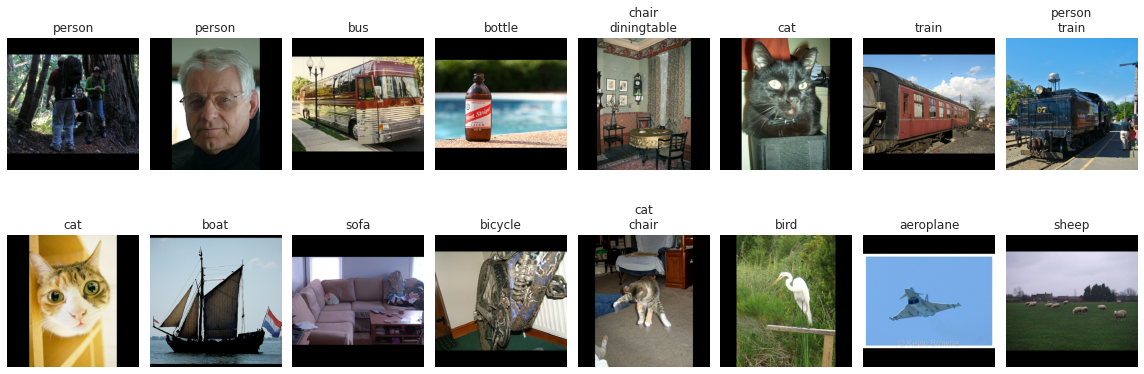

In [20]:
#@title

for images, labels in valid.take(1):
  gt = ['\n'.join(CLASSES[l].astype(str))
        for l in labels.numpy().astype(bool)]

  visualize(
    to_image(images[:16]),
    gt,
    rows=2,
    figsize=(16, 6)
  )

## Network

In [21]:
print(f'Loading {Config.model.backbone.__name__}')

backbone = Config.model.backbone(
  input_shape=Config.data.shape,
  include_top=Config.model.include_top,
  classifier_activation=Config.model.classifier_activation,
)

Loading ResNet101V2
171319296/171317808 [==============================] - 3s 0us/step


In [23]:
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D

class DenseKur(Dense):
  """Dense with Softmax Weights.
  """
  def call(self, inputs):
    kernel = self.kernel
    ag = kernel  # tf.abs(kernel)
    ag = ag - tf.reduce_max(ag, axis=-1, keepdims=True)
    ag = tf.nn.softmax(ag)

    outputs = inputs @ (ag*kernel)

    if self.use_bias:
      outputs = tf.nn.bias_add(outputs, self.bias)

    if self.activation is not None:
      outputs = self.activation(outputs)

    return outputs

In [30]:
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D


def build_specific_classifier(
    backbone,
    classes,
    dropout_rate=0.5,
    name=None,
    gpl='avg_pool',
):
  # x = tf.keras.Input((Config.data.shape), name='images')
  # y = backbone(x)
  x = backbone.input
  y = backbone.output
  y = GlobalAveragePooling2D(name='avg_pool')(y)
  y = Dropout(rate=dropout_rate, name='top_dropout')(y)
  y = Dense(classes, name='predictions')(y)

  return tf.keras.Model(
    x,
    y,
    name=name,
  )

backbone.trainable = False

nn = build_specific_classifier(backbone, len(CLASSES), name='enb7_voc_20',
                                gpl=Config.model.pool_layer)

In [ ]:
tf.keras.utils.plot_model(nn, show_shapes=True)

In [32]:
if Config.model.fine_tune_layers:
  print(f'Unfreezing {Config.model.fine_tune_layers:.0%} layers.')

  backbone.trainable = True
  frozen_layer_ix = int((1-Config.model.fine_tune_layers) * len(backbone.layers))

  for ix, l in enumerate(backbone.layers):
    l.trainable = (ix > frozen_layer_ix and
                  (not isinstance(l, tf.keras.layers.BatchNormalization) or
                    not Config.model.freeze_batch_norm))
  
print(f'Loading weights from {Config.experiment.weights}')
nn.load_weights(Config.experiment.weights)

Unfreezing 60% layers.
Loading weights from /content/drive/MyDrive/logs/pascal/resnet101-ce-dropout-fine-tune/weights.h5


In [33]:
nn_s = tf.keras.Model(
  inputs=nn.inputs,
  outputs=[nn.output, nn.get_layer(Config.model.pool_layer).input],
  name='nn_spatial')

## Study of the Sigmoid Layer

The logits for the *sigmoid* classifier are defined by:

$f(x)_u = w^k_u \cdot \frac{1}{HW} \sum_{i,j} A^k_{i,j} $

Hence, the importance of each kernel $A^k$ for the classification of class $u$
is given by: $|w^u| = [|w^u_0|, |w^u_1|, \ldots, |w^u_K|]$.

In [34]:
sW, sb = nn.layers[-1].weights

In [35]:
# sWSoft = sW * tf.nn.softmax(sW - tf.reduce_max(sW, axis=-1, keepdims=True))

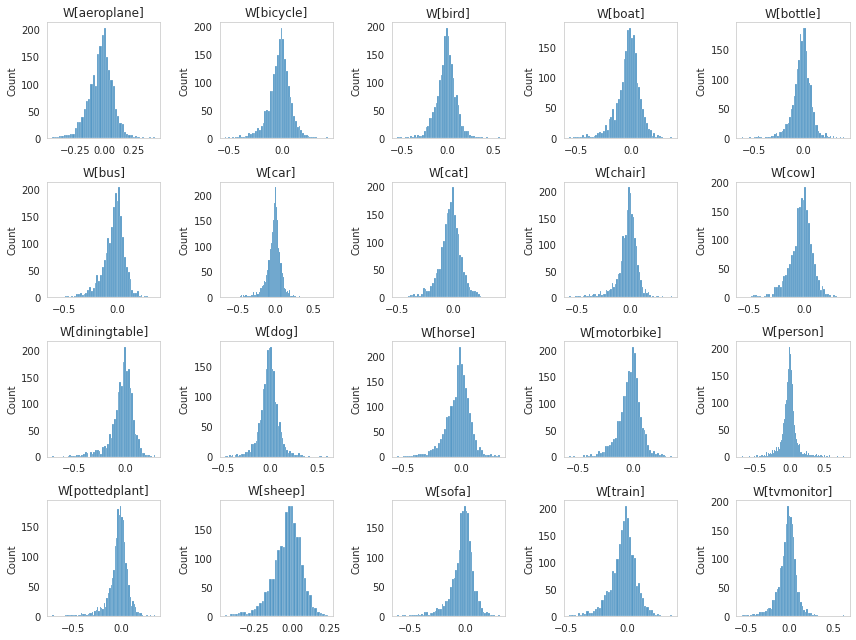

In [38]:
#@title Weights Histogram per Activation Unit

plt.figure(figsize=(12, 9))

for u in range(len(CLASSES)):
  k_indices = tf.argsort(sW[:, u], direction='DESCENDING')
  k_importances = tf.gather(sW[:, u], k_indices)

  plt.subplot(4, 5, u+1)
  sns.histplot(k_importances)
  plt.title(f'W[{CLASSES[u]}]')

plt.tight_layout();

* Classes are sparsely linked with kernels.  
  Most kernels do not matter to classify an object.
* Some of the classes (e.g. `diningtable`, `horse`, `bottle`) have more negative connections than positive.  
  Possible reason: they might be learning to discriminate objects based on what they are not, instead of what they actually are.

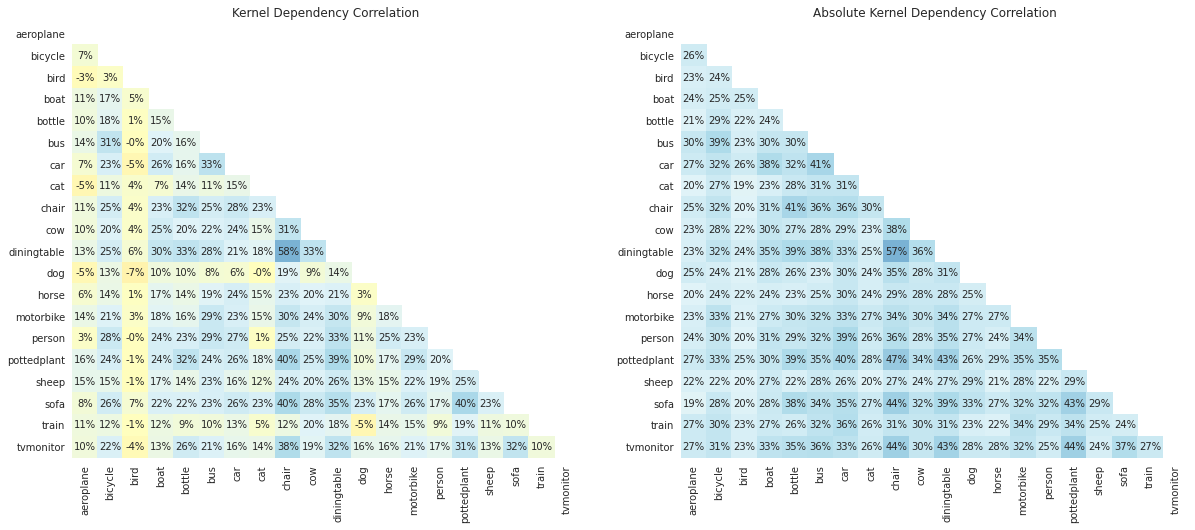

In [39]:
#@title Correlation between Weights

c = np.ones((len(CLASSES), len(CLASSES)))
ca = np.ones_like(c)

for u in range(len(CLASSES)):
  for v in range(u+1, len(CLASSES)):
    c[u, v] = c[v, u] = np.corrcoef(sW[:, u], sW[:, v])[0, 1]
    ca[u, v] = ca[v, u] = np.corrcoef(tf.abs(sW[:, u]), tf.abs(sW[:, v]))[0, 1]
  
mask = np.zeros_like(c)
mask[np.triu_indices_from(mask)] = True


## Chart
#

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.title('Kernel Dependency Correlation')
sns.heatmap(c, annot=True, fmt='.0%', xticklabels=CLASSES, yticklabels=CLASSES, cmap='RdYlBu', center=0, cbar=False, vmin=-1, vmax=1, mask=mask)

plt.subplot(122)
plt.title('Absolute Kernel Dependency Correlation')
sns.heatmap(ca, annot=True, fmt='.0%', xticklabels=CLASSES, yticklabels=CLASSES, cmap='RdYlBu', center=0, cbar=False, vmin=-1, vmax=1, mask=mask);

Classes `diningtable-chair`, `pottleplant-sofa` have a strong kernel correlation.  
They are accepting/negating the same kernels to classify their objects.

In [ ]:
#@title

def most_important_synaptic_connections(w, K):
  w = tf.transpose(w)

  labels = tf.repeat(tf.range(w.shape[0]), [K])
  k_indices = tf.argsort(w, direction='DESCENDING')[..., :K]
  return pd.DataFrame({
    'Label': CLASSES[labels.numpy()],
    'Kernel': k_indices.numpy().ravel().astype(str),
    'Value': tf.gather(w, k_indices, axis=1, batch_dims=1).numpy().ravel()
  })

def activations_per_label(dataset, w):
  activations = tf.zeros((w.shape[0], len(CLASSES)))
  detections = tf.zeros([len(CLASSES)])

  for x, y in dataset:
    l, a = nn_s(x)
    p = tf.nn.sigmoid(l)

    gap = tf.reduce_mean(a, axis=(-3, -2))
    ay = tf.einsum('bk,bc->kc', gap, y)

    activations += ay
    detections += tf.reduce_sum(y, axis=0, keepdims=True)

    print('.', end='')
  
  return activations, detections

In [ ]:
ay, detections = activations_per_label(valid.take(4), sWSoft)

....

In [ ]:
links_wc = most_important_synaptic_connections(sW, K=10)[['Kernel', 'Label', 'Value']]

In [ ]:
#@title Average Kernel Activation per Ground-Truth Label


## Only check for inputs that matter for the output:

kernels_of_interest = np.sort(links_wc.Kernel.astype(int).unique())
avg_act_intensity = (ay / detections).numpy()
avg_act_intensity = avg_act_intensity[kernels_of_interest, :]

links_ia = pd.DataFrame({
  'Label': np.repeat(CLASSES, len(kernels_of_interest)),
  'Kernel': np.tile(kernels_of_interest, len(CLASSES)).astype(str),
  'Value': avg_act_intensity.T.ravel()
})
links_ia = links_ia.groupby(['Label']).apply(lambda x: x.nlargest(10, ['Value'])).reset_index(drop=True)


# Sankey

hv.extension('bokeh')

flow = hv.Sankey(links_ia)
flow.opts(opts.Sankey(
  edge_color='Kernel',
  width=900, height=900, cmap='Set1', label_position='right'))

In [ ]:
#@title Kernel Importance per Classifier

hv.extension('bokeh')

flow = hv.Sankey(links_wc)
flow.opts(opts.Sankey(
  edge_color='Label',
  width=900, height=900, cmap='Set1', label_position='left'))

### What Happens when Detecting Seldomly Co-occurring Examples

In [ ]:
! unzip -qn /content/drive/MyDrive/unicamp_datasets/dogs-and-birds.zip -d ./examples/

examples = (tf.keras
            .preprocessing.image_dataset_from_directory('examples', label_mode=None, image_size=Config.data.size, shuffle=False)
            .map(lambda x: preprocess(default_policy_fn(x))))

for x in examples:
  probs = nn(x, training=False)
  probs = tf.nn.sigmoid(probs)

Found 18 files belonging to 1 classes.


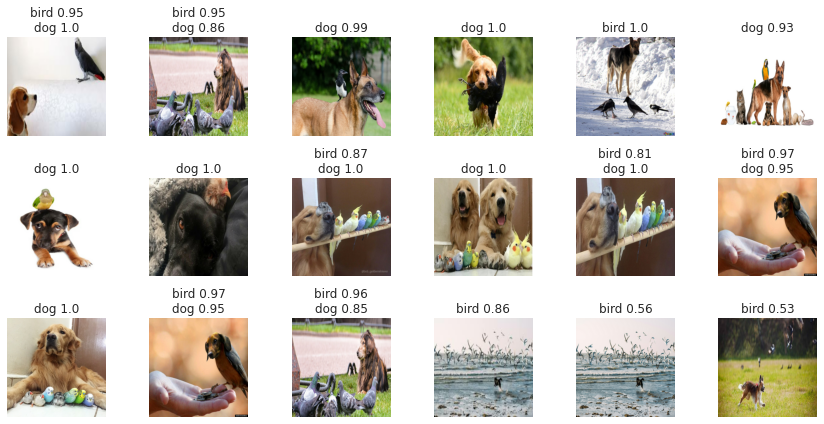

In [ ]:
#@title

visualize(
  to_image(x),
  [
    '\n'.join(map(' '.join, zip(CLASSES[p > 0.5], map(str, p[p > 0.5]))))
    for p in probs.numpy().round(2)
  ],
  rows=3,
  figsize=(12, 6))